In [1]:
import os
from pathlib import Path
from IPython.display import Image, display
os.chdir("/Users/oliverdaniels-koch/projects/elk-experiments")
out_dir = Path("output")
device = "cpu"

# Explore EAP Graphs on Hex

I'm curious if we see notable differences when running (aggregated) edge attribution patching 
on the trusted and untrusted data of the hex task

I suspect there's a lot of in-distribution variation, but maybe we'll see two distinct circuits?

I also want to create a detector using k-means clustering?

I guess there's just a bunch of ways to learn a latent space of the adjacency / score matrix

Seems like there should be something smarter 

In [2]:
from functools import partial


import torch 
import numpy as np

from cupbearer import tasks, detectors, scripts, utils
from cupbearer.detectors import ActivationCache
from cupbearer.detectors.statistical import MahalanobisDetector
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
from elk_experiments.utils import train_detector_cache, learn_graph_cache, get_activation_at_last_token
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.eap_detector import EAPDetector, layer_edge_filter, effect_prob_func, set_model


In [3]:
task_name = "ifelse"
model_name = "pythia-70m"
nodes = ["head", "mlp"]

In [4]:
graph_dir = out_dir / f"subset_graphs_{task_name}_{model_name}_{'_'.join(nodes)}"
graph_dir.mkdir(exist_ok=True)

In [5]:
task = tasks.tiny_natural_mechanisms(task_name, device, model_name)


Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cpu


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  cpu


In [6]:
def effect_prob_func(logits, effect_tokens, output=None, inputs=None):
    assert logits.ndim == 3
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    probs = logits[:, -1, :].softmax(dim=-1)
    out = probs[:, effect_tokens].mean() # mean over effect tokens, mean over batch
    # out = logits[:, -1, effect_tokens].mean()
    return out

In [7]:
task.model.set_use_hook_mlp_in(True)
task.model.set_use_split_qkv_input(True)
task.model.set_use_attn_result(True)

In [8]:
small_task = get_task_subset(task, 2048, 1048, 1024)

In [10]:
effect_tokens = task.model.tokenizer.encode(" else")[1:]

In [12]:
trusted_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.trusted_data.data])
untrusted_clean_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.test_data.normal_data.data])
anomalous_tokens = torch.stack([torch.tensor(data["prefix_tokens"]) for data in small_task.test_data.anomalous_data.data])

In [13]:
if task_name == "ifelse":
    threshold = 2e-6
elif task_name == "hex":
    threshold = 1e-7
else: 
    raise ValueError("task not recognized")

## Trusted Data Graph

In [14]:
graph_dir

PosixPath('output/subset_graphs_ifelse_pythia-70m_head_mlp')

In [12]:
graph_dir = out_dir / f"subset_graphs_{task_name}_{model_name}"
clean_graph_path = graph_dir / "clean_graph.pt"
task.model.reset_hooks()

clean_graph = learn_graph_cache(
    model=task.model,
    tokens=trusted_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=clean_graph_path,
    verbose=True
)

Saving activations requires 0.0001 GB of memory per token


In [13]:
clean_graph.top_edges(n=20, abs_scores=False)

[('head.0.3', 'head.1.1.v', 5.559661985898856e-06),
 ('head.0.6', 'head.3.3.v', 5.269548637443222e-06),
 ('head.0.3', 'head.1.3.v', 5.163328751223162e-06),
 ('head.0.3', 'head.1.4.v', 3.380461976121296e-06),
 ('head.0.0', 'head.1.6.v', 2.9738814646407263e-06),
 ('head.0.6', 'head.1.0.v', 2.856041874110815e-06),
 ('head.0.0', 'head.3.7.v', 2.6508582777751144e-06),
 ('head.0.3', 'head.2.0.v', 2.5859685592877213e-06),
 ('head.0.0', 'head.2.6.v', 2.431959956084029e-06),
 ('head.0.6', 'head.2.2.v', 2.379960733378539e-06),
 ('head.0.1', 'head.2.5.v', 2.368967898291885e-06),
 ('head.0.5', 'head.1.0.v', 2.3241032067744527e-06),
 ('head.2.0', 'head.3.7.v', 2.320241492270725e-06),
 ('head.0.3', 'head.1.2.v', 1.991269755308167e-06),
 ('head.0.0', 'head.2.5.v', 1.9279777916381136e-06),
 ('head.2.2', 'head.3.2.v', 1.8308096514374483e-06),
 ('head.0.1', 'head.3.4.v', 1.7554780242790002e-06),
 ('head.0.0', 'head.1.6.q', 1.7022356360030244e-06),
 ('head.0.6', 'head.3.1.v', 1.6879980648809578e-06),
 ('

In [15]:
graph_dir = out_dir / f"subset_graphs_{task_name}_{model_name}_{'_'.join(nodes)}"
clean_graph_path = graph_dir / "clean_graph_16_cpu.pt"
task.model.reset_hooks()

clean_graph = learn_graph_cache(
    model=task.model,
    tokens=trusted_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=clean_graph_path,
    verbose=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saving activations requires 0.0001 GB of memory per token


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


In [16]:
clean_graph.top_edges(n=20, abs_scores=False)

[('head.2.1', 'head.4.2.k', 0.00020726429647766054),
 ('head.0.7', 'head.1.3.v', 0.00020685970957856625),
 ('head.0.3', 'head.1.0.v', 0.0001653019862715155),
 ('head.0.6', 'head.1.0.v', 0.00015572807751595974),
 ('head.0.3', 'head.1.4.v', 0.00015254637401085347),
 ('head.0.5', 'head.1.4.v', 0.00014599543646909297),
 ('head.0.4', 'head.1.3.v', 0.0001414381549693644),
 ('head.0.3', 'head.1.3.v', 0.00013786180352326483),
 ('head.0.6', 'head.1.1.v', 0.0001330200320808217),
 ('head.0.0', 'head.1.7.v', 0.00013047936954535544),
 ('head.0.1', 'head.1.6.v', 0.00012605820666067302),
 ('head.0.1', 'head.2.5.v', 0.00011023734987247735),
 ('head.0.3', 'head.2.7.v', 0.00010331512021366507),
 ('head.0.3', 'head.1.2.v', 0.0001024979428621009),
 ('head.0.5', 'head.1.3.v', 0.00010240987467113882),
 ('head.0.2', 'head.2.0.v', 9.829323244048283e-05),
 ('head.0.5', 'head.3.7.v', 9.814705117605627e-05),
 ('head.0.0', 'head.1.6.v', 9.694180334918201e-05),
 ('head.3.2', 'head.4.2.q', 9.291953028878197e-05),
 

In [ ]:
fname = "clean_graph.png"
clean_graph.show(threshold=threshold, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [ ]:
clean_edges = clean_graph.top_edges(threshold=threshold, abs_scores=False)
len(clean_edges)

## Anomalous Data Graph

In [ ]:
anomalous_graph_path = graph_dir / "anomalous_graph.pt"

task.model.reset_hooks()

anomalous_graph = learn_graph_cache(
    model=task.model,
    tokens=anomalous_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=anomalous_graph_path,
    verbose=True
)

In [ ]:
fname = "anom_graph.png"
anomalous_graph.show(threshold=threshold, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [ ]:
anomalous_edges = anomalous_graph.top_edges(threshold=threshold, abs_scores=False)
len(anomalous_edges)

## Untrusted Clean Data Graph

In [ ]:
task.model.reset_hooks()

untrusted_clean_path = graph_dir / "untrusted_clean_graph.pt"

untrusted_clean_graph = learn_graph_cache(
    model=task.model,
    tokens=untrusted_clean_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=untrusted_clean_path,
    verbose=True
)

In [ ]:
untrusted_clean_graph.top_edges(threshold=2e-6, abs_scores=False)

In [ ]:
fname = "untrusted_clean_graph.png"
untrusted_clean_graph.show(threshold=2e-6, abs_scores=False, fdir=graph_dir, fname=fname)
display(Image(graph_dir / fname))

In [ ]:
untrusted_clean_edges = untrusted_clean_graph.top_edges(threshold=threshold, abs_scores=False)
len(untrusted_clean_edges)

## Combined Graph

In [ ]:
all_tokens = torch.cat([trusted_tokens, anomalous_tokens, untrusted_clean_tokens])

In [ ]:
full_graph_path = graph_dir / "full_graph.pt"

task.model.reset_hooks()

full_graph = learn_graph_cache(
    task.model,
    all_tokens,
    partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=nodes,
    downstream_nodes=nodes,
    batch_size=128,
    cache_path=full_graph_path,
    verbose=True
)

In [ ]:
fname = "full_graph.png"
full_graph.show(threshold=threshold, abs_scores=True, fname=fname, fdir=graph_dir)
display(Image(graph_dir / fname))

In [ ]:
full_edges = full_graph.top_edges(threshold=threshold, abs_scores=True)
len(full_edges)

##  Untrusted Combined

In [ ]:
untrusted_tokens = torch.cat([anomalous_tokens, untrusted_clean_tokens])

In [ ]:
untrusted_path = graph_dir / "untrusted_graph.pt"

task.model.reset_hooks()

untrusted_graph = learn_graph_cache(
    task.model,
    untrusted_tokens,
    partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    batch_size=128,
    cache_path=untrusted_path,
    verbose=True
)

In [ ]:
fname = "untrusted_graph.png"
untrusted_graph.show(threshold=threshold, abs_scores=False, fname=fname, fdir=graph_dir)
display(Image(graph_dir / fname))

In [ ]:
untrusted_edges = untrusted_graph.top_edges(threshold=threshold, abs_scores=False)
len(untrusted_edges)

# Detectors Using EAP Graphs

In [14]:
from elk_experiments.utils import train_detector_cache
from elk_experiments.eap_detector import EAPDetector
from cupbearer.detectors import ActivationCache
from cupbearer.detectors import MahalanobisDetector
from cupbearer import utils

In [15]:
class EAPMahalanobisDetector(EAPDetector, MahalanobisDetector):
    pass

In [16]:
def edge_set_filter(edge, edge_set):
    return tuple(edge) in edge_set

## Standard Detector

In [17]:
# maybe the problem is that the psedoinverse basically compresses the dimensions of variation between the training and test data

# should try more basic method (number of anomolous edges)

In [20]:
# cache = ActivationCache(device)
detector_dir = graph_dir / "standard_detector"

detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=lambda x: True,
    layer_aggregation="mean", 
    cache=None
)

2024-07-13 06:35:09.467 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([2880])
100%|██████████| 32/32 [01:57<00:00,  3.67s/it]
2024-07-13 06:37:11.410 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:266 - Saving detector to output/subset_graphs_ifelse_pythia-70m_head_mlp/standard_detector/detector


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-13 06:39:39.271 | INFO     | cupbearer.detectors.anomaly_detector:plot_scores:35 - AUC_ROC (all): 0.9015
2024-07-13 06:39:39.283 | INFO     | cupbearer.detectors.anomaly_detector:plot_scores:36 - AP (all): 0.8757


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9014835357666016,
               'AP': 0.8756506758885498}}),
 {'all': <Figure size 640x480 with 1 Axes>})

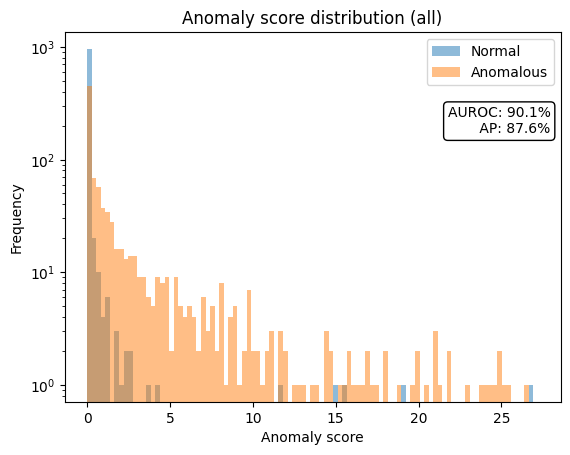

In [21]:
train_detector_cache(
    detector_dir=detector_dir,
    detector=detector,
    task=small_task,
    batch_size=64,
    eval_batch_size=64,
    cache=None,
    overwrite=True
)

In [22]:
task.model.tokenizer.add_bos_token

True

In [ ]:
trusted_tokens.shape

In [ ]:
# check detector scores varying on batch size
scores_batch = detector.scores(trusted_tokens[0:5])

In [ ]:
scores_single = [detector.scores(trusted_tokens[i].unsqueeze(0)) for i in range(5)]


In [ ]:
eap_scores_batch = detector.get_activations(trusted_tokens[0:5])

In [ ]:
eap_scores_single = [detector.get_activations(trusted_tokens[i].unsqueeze(0)) for i in range(5)]

In [ ]:
eap_scores_single_reverse = [detector.get_activations(trusted_tokens[5-i-1].unsqueeze(0)) for i in range(5)]

In [ ]:
eap_scores_batch["eap_scores"][0].flatten()

In [ ]:
torch.abs(eap_scores_batch["eap_scores"][0].flatten() - eap_scores_single[0]["eap_scores"].flatten()).median()

In [ ]:
torch.where(torch.abs(eap_scores_batch["eap_scores"][0].flatten() - eap_scores_single[0]["eap_scores"].flatten()) > 1e-1)

In [ ]:
scores_single, scores_batch

## Clean Edges

### Pos Only

In [ ]:
clean_edge_names = [(edge[0], edge[1]) for edge in clean_edges]
len(clean_edge_names)

In [ ]:
detector_dir = graph_dir / "clean_edges"

In [ ]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=clean_edge_names),
    layer_aggregation="mean", 
    cache=None, 
)

In [ ]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=64, 
    eval_batch_size=64, 
    cache=None, 
    cache_path=None,
    overwrite=True,
)

### Abs Value

In [ ]:
clean_graph.show(threshold=threshold, abs_scores=True, fdir=graph_dir, fname="clean_graph_abs.png")
display(Image(graph_dir / "clean_graph_abs.png"))


In [ ]:
clean_abs_edges = clean_graph.top_edges(threshold=threshold, abs_scores=True)
clean_abs_edges

In [ ]:
clean_abs_edge_names = [(edge[0], edge[1]) for edge in clean_abs_edges]
len(clean_abs_edge_names)

In [ ]:
detector_dir = graph_dir / "clean_abs_edges"

In [ ]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=clean_abs_edge_names),
    layer_aggregation="mean", 
    cache=None, 
)

In [ ]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=64, 
    eval_batch_size=64, 
    cache=None, 
    cache_path=None,
    overwrite=False,
)

##  Full Edges

In [ ]:
full_abs_edges = full_graph.top_edges(threshold=threshold, abs_scores=True)
len(full_abs_edges)

In [ ]:
full_abs_edges_names = [(edge[0], edge[1]) for edge in full_abs_edges]
len(full_abs_edges)

In [ ]:
detector_dir = graph_dir / "full_abs_edges"

In [ ]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=nodes,
    downstream_nodes=nodes,
    edge_filter=partial(edge_set_filter, edge_set=full_abs_edges_names),
    layer_aggregation="mean", 
    cache=None, 
)

In [ ]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=128, 
    eval_batch_size=128, 
    cache=None, 
    cache_path=None,
    overwrite=True,
)

In [ ]:
detector.load_weights(detector_dir / "detector.pt")

In [ ]:
import sklearn
from torch.utils.data import DataLoader
from collections import defaultdict
from loguru import logger
from tqdm import tqdm

In [ ]:
dataset = small_task.test_data
batch_size: int = 128
histogram_percentile: float = 95
save_path: Path | str | None = None
num_bins: int = 100
pbar: bool = True
layerwise: bool = False
log_yaxis: bool = True


In [ ]:
detector.set_model(small_task.model)

In [ ]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    # For some methods, such as adversarial abstractions, it might matter how
    # normal/anomalous data is distributed into batches. In that case, we want
    # to mix them by default.
    shuffle=True,
)

metrics = defaultdict(dict)
assert 0 < histogram_percentile <= 100

if pbar:
    test_loader = tqdm(test_loader, desc="Evaluating", leave=False)

scores = defaultdict(list)
labels = defaultdict(list)

# It's important we don't use torch.inference_mode() here, since we want
# to be able to override this in certain detectors using torch.enable_grad().
with torch.no_grad():
    for batch in test_loader:
        inputs, new_labels = batch
        if layerwise:
            new_scores = detector.layerwise_scores(inputs)
        else:
            new_scores = {"all": detector.scores(inputs)}
        for layer, score in new_scores.items():
            if isinstance(score, torch.Tensor):
                score = score.cpu().numpy()
            assert score.shape == new_labels.shape
            scores[layer].append(score)
            labels[layer].append(new_labels)
scores = {layer: np.concatenate(scores[layer]) for layer in scores}
labels = {layer: np.concatenate(labels[layer]) for layer in labels}

In [ ]:
upper_lim = np.percentile(scores[layer], histogram_percentile).item()
# Usually there aren't extremely low outliers, so we just use the minimum,
# otherwise this tends to weirdly cut of the histogram.
lower_lim = scores[layer].min().item()

bins = np.linspace(lower_lim, upper_lim, num_bins)

In [ ]:
upper_lim = np.percentile(scores[layer], 100).item()
upper_lim

In [ ]:
histogram_percentile = 100

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
figs = {}

for layer in scores:
    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels[layer],
        y_score=scores[layer],
    )
    ap = sklearn.metrics.average_precision_score(
        y_true=labels[layer],
        y_score=scores[layer],
    )
    logger.info(f"AUC_ROC ({layer}): {auc_roc:.4f}")
    logger.info(f"AP ({layer}): {ap:.4f}")
    metrics[layer]["AUC_ROC"] = auc_roc
    metrics[layer]["AP"] = ap

    upper_lim = np.percentile(scores[layer], histogram_percentile).item()
    # Usually there aren't extremely low outliers, so we just use the minimum,
    # otherwise this tends to weirdly cut of the histogram.
    lower_lim = scores[layer].min().item()

    bins = np.linspace(lower_lim, upper_lim, num_bins)

    # Visualizations for anomaly scores
    fig, ax = plt.subplots()
    for i, name in enumerate(["Normal", "Anomalous"]):
        vals = scores[layer][labels[layer] == i]
        ax.hist(
            vals,
            bins=bins,
            alpha=0.5,
            label=name,
            log=log_yaxis,
        )
    ax.legend()
    ax.set_xlabel("Anomaly score")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Anomaly score distribution ({layer})")
    textstr = f"AUROC: {auc_roc:.1%}\n AP: {ap:.1%}"
    props = dict(boxstyle="round", facecolor="white")
    ax.text(
        0.98,
        0.80,
        textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=props,
    )
    figs[layer] = fig


In [ ]:
train_detector_cache(
    detector_dir, 
    detector, 
    small_task, 
    batch_size=128, 
    eval_batch_size=128, 
    cache=None, 
    cache_path=None,
    overwrite=True,
)

In [ ]:
# check for hash tags in training set
decoded_train_set = [small_task.model.tokenizer.decode(x["prefix_tokens"]) for x in small_task.trusted_data.data]
decoded_clean_untrusted = [small_task.model.tokenizer.decode(x["prefix_tokens"]) for x in small_task.test_data.normal_data.data]


In [ ]:
has_hash_train = [x for x in decoded_train_set if "#" in x]
has_hash_clean_untrusted = [x for x in decoded_clean_untrusted if "#" in x]
len(has_hash_train), len(has_hash_clean_untrusted)

In [ ]:
has_hash_clean_untrusted_idxs = [i for i, x in enumerate(decoded_clean_untrusted) if "#" in x]
has_hash_clean_untrusted_tokens = untrusted_clean_tokens[has_hash_clean_untrusted_idxs]

In [ ]:
untrusted_clean_tokens.shape

In [ ]:
has_hash_clean_untrusted_tokens.shape

In [ ]:
detector.set_model(small_task.model)

In [ ]:
task.model(has_hash_clean_untrusted_tokens)[1] 

In [ ]:
task.model(has_hash_clean_untrusted_tokens[1].unsqueeze(0))

In [ ]:
sum(hex_scores) / len(hex_scores)

In [ ]:
hex_acts = detector.get_activations(has_hash_clean_untrusted_tokens)

In [ ]:
single_act = detector.get_activations(has_hash_clean_untrusted_tokens[1].unsqueeze(0))

In [ ]:
single_act["eap_scores"].shape

In [ ]:
hex_acts["eap_scores"].shape

In [ ]:
hex_scores = detector.scores(has_hash_clean_untrusted_tokens)

In [ ]:
clean_scores = scores["all"][labels["all"] == 0]
anomalous_scores = scores["all"][labels["all"] == 1]

In [ ]:
np.median(clean_scores), np.median(anomalous_scores), np.mean(clean_scores), np.mean(anomalous_scores)

In [ ]:
np.sort(clean_scores)[-10:]

In [ ]:
has_hash_clean_untrusted

In [ ]:
small_task_no_hash = get_task_subset(task, 2048, 1024, 1024)

In [ ]:
len(small_task_no_hash.test_data.normal_data.data)

In [ ]:
small_task_no_hash.test_data.normal_data.data

In [ ]:
filtered_test_data = [x for x in small_task_no_hash.test_data.normal_data.data if "#" not in small_task_no_hash.model.tokenizer.decode(x["prefix_tokens"])]

In [ ]:
from cupbearer.data import MixedData
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset

In [ ]:
test_data = MixedData(TinyNaturalMechanismsDataset(filtered_test_data), small_task_no_hash.test_data.anomalous_data, return_anomaly_labels=False)

In [ ]:
small_task_no_hash.test_data = test_data

In [ ]:
num_left_over = len(small_task_no_hash.test_data.normal_data.data) % 64

In [ ]:
small_task_no_hash.test_data.normal_data.data = small_task_no_hash.test_data.normal_data.data[:-num_left_over]

In [ ]:
#TODO: figure out what's going on here

In [ ]:
# eval on untrusted data without hash tags
scripts.eval_detector(
    small_task_no_hash,
    detector,
    save_path=Path(str(detector_dir) + "_no_hash"),
    pbar=True, 
    batch_size=128
)

# Filter Detector by Edge Difference Between Untrusted and Trusted

In [ ]:
trusted_edge_names = [edge[:2] for edge in clean_edges]
untrusted_edge_names = [edge[:2] for edge in untrusted_edges]
edge_diff = set(untrusted_edge_names) - set(trusted_edge_names)
len(edge_diff)


In [ ]:
edge_diff

In [ ]:
detector_dir = out_dir / "pythia-70m-hex-small-untrusted_diff"

In [ ]:
cache = ActivationCache(device=device)

In [ ]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(edge_set_filter, edge_set=edge_diff),
    seq_len=16,
    layer_aggregation="mean", 
    cache=cache
)

In [ ]:
train_detector_cache(
    detector_dir, detector, small_task, batch_size=128, eval_batch_size=128, cache=cache, 
    cache_path=None, overwrite=True, overwrite_cache=True
)

In [ ]:
detector.means["eap_scores"]

In [ ]:
detector.covariances["eap_scores"].diag()

# Try Getting Top Edges across Entire Distribution, filtering anomolies with respect to that